In [2]:
from sklearn import preprocessing
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth=200)

sns.set_theme(style='darkgrid')


In [3]:
train = pd.read_csv('train.csv')
train_index = train.index
y = train['Survived']

test = pd.read_csv('test.csv')


df = pd.concat([train, test], ignore_index=True)

test_index = df.index[-test.shape[0]:]


In [4]:
test_index


RangeIndex(start=891, stop=1309, step=1)

Preprocessing


In [5]:
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.3,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.1,NaN,S


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
df.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.0,891.0,1309.0,1046.0,1309.0,1309.0,1308.0
mean,655.0,0.4,2.3,29.9,0.5,0.4,33.3
std,378.0,0.5,0.8,14.4,1.0,0.9,51.8
min,1.0,0.0,1.0,0.2,0.0,0.0,0.0
25%,328.0,0.0,2.0,21.0,0.0,0.0,7.9
50%,655.0,0.0,3.0,28.0,0.0,0.0,14.5
75%,982.0,1.0,3.0,39.0,1.0,0.0,31.3
max,1309.0,1.0,3.0,80.0,8.0,9.0,512.3


In [8]:
def remove_other_elements(s, keep):
    res = ''
    for el in s:
        if el in keep:
            res += el
    if res == '':
        res = '0'
    return res


In [9]:
df['Ticket'] = df['Ticket'].apply(
    lambda x: remove_other_elements(str(x), '0123456789')[:1]).astype(int)


In [13]:
df['Cabin'] = df['Cabin'].fillna('N/A')
df['Cabin'] = df['Cabin'].apply(lambda x: str(x)[:1] if x != 'N/A' else 'N/A')
df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,5,7.2,N/A,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,1,71.3,C,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,2,7.9,N/A,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,1,53.1,C,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,3,8.1,N/A,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,5,8.1,N/A,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,1,108.9,C,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,3,7.2,N/A,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,3,8.1,N/A,S


In [15]:
for_dropping = []
for_dropping.extend(df.loc[df['Cabin'] == 'T'].index.to_numpy())


In [19]:
def define_age_type(age):
    if age < 18:
        return 'Young'
    elif age < 60:
        return 'Adult'
    else:
        return 'Old'


In [20]:
df['Age_type'] = df['Age'].apply(define_age_type)
df['Age_type']


0       Adult
1       Adult
2       Adult
3       Adult
4       Adult
        ...  
1304      Old
1305    Adult
1306    Adult
1307      Old
1308      Old
Name: Age_type, Length: 1309, dtype: object

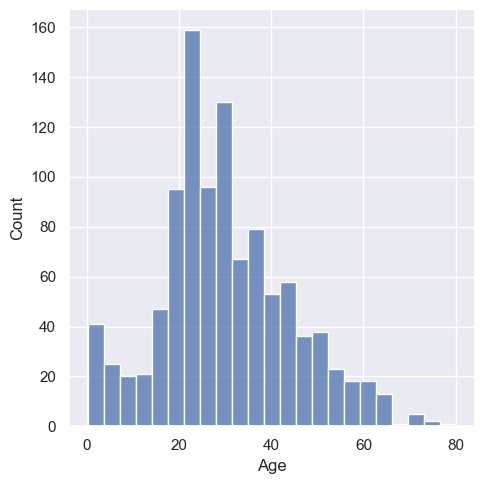

In [21]:
sns.displot(df['Age'])
# Looks a bit better


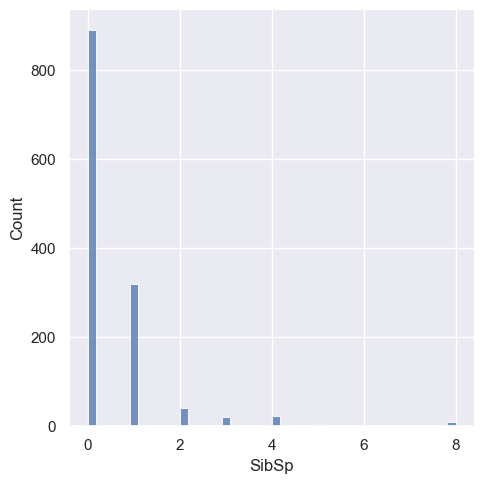

In [22]:
sns.displot(df['SibSp'])


Preprocessing


In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   int32  
 9   Fare         1308 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1307 non-null   object 
 12  Age_type     1309 non-null   object 
dtypes: float64(3), int32(1), int64(4), object(5)
memory usage: 128.0+ KB


In [24]:
df.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare
count,1309.0,891.0,1309.0,1046.0,1309.0,1309.0,1309.0,1308.0
mean,655.0,0.4,2.3,29.9,0.5,0.4,2.4,33.3
std,378.0,0.5,0.8,14.4,1.0,0.9,1.3,51.8
min,1.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0
25%,328.0,0.0,2.0,21.0,0.0,0.0,1.0,7.9
50%,655.0,0.0,3.0,28.0,0.0,0.0,2.0,14.5
75%,982.0,1.0,3.0,39.0,1.0,0.0,3.0,31.3
max,1309.0,1.0,3.0,80.0,8.0,9.0,9.0,512.3


In [25]:
# We see the min and max of the Age, SibSp, and Fare are highly different
# from the average value.


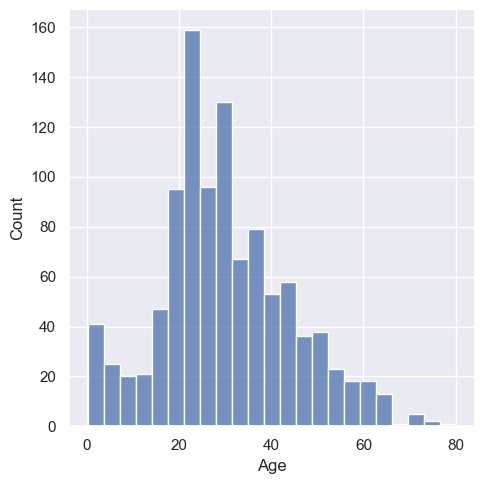

In [26]:
sns.displot(df['Age'])


<AxesSubplot: >

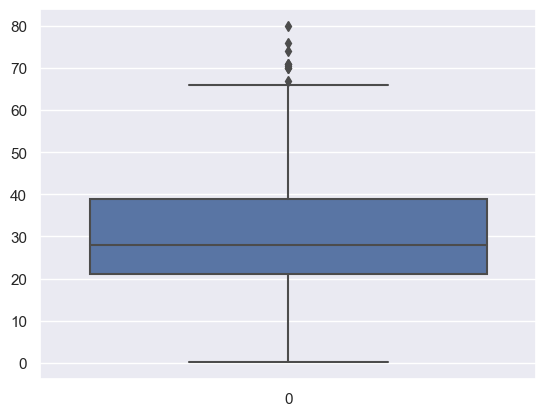

In [27]:
sns.boxplot(df['Age'])

# I'll combine people above 65 age old in one group


In [28]:
df.loc[df['Age'] > 65, 'Age'] = df.loc[df['Age'] > 65, 'Age'].mean()


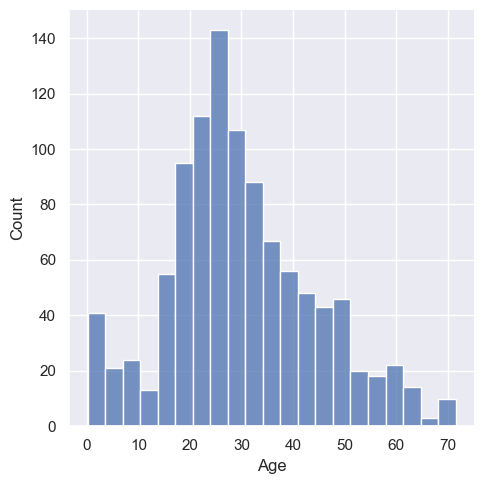

In [29]:
sns.displot(df['Age'])

# Looks a bit better


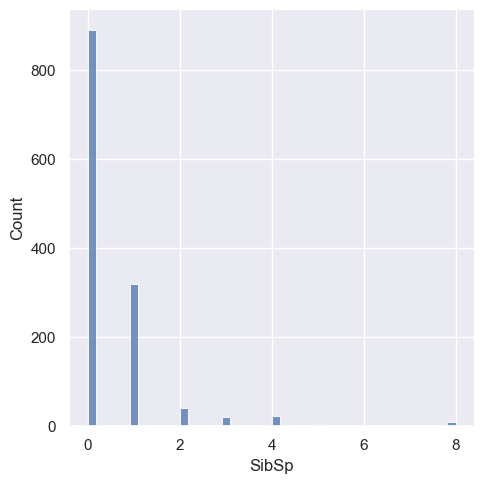

In [30]:
sns.displot(df['SibSp'])


<AxesSubplot: xlabel='Parch', ylabel='Age'>

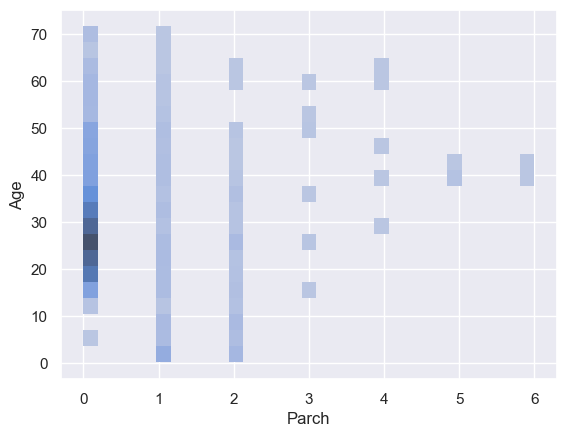

In [31]:
sns.histplot(data=df,
             x='Parch',
             y='Age',
             multiple='stack',
             shrink=0.5)


In [32]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   int32  
 9   Fare         1308 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1307 non-null   object 
 12  Age_type     1309 non-null   object 
dtypes: float64(3), int32(1), int64(4), object(5)
memory usage: 128.0+ KB


In [44]:
df.loc[df['Name'].apply(lambda x: 'Master' in x), 'Age'].describe()


count   53.0
mean     5.5
std      4.2
min      0.3
25%      2.0
50%      4.0
75%      9.0
max     14.5
Name: Age, dtype: float64

In [46]:
df.loc[df['Age'] < 16, ['Name']]


,Name
7,"Palsson, Master. Gosta Leonard"
9,"Nasser, Mrs. Nicholas (Adele Achem)"
10,"Sandstrom, Miss. Marguerite Rut"
14,"Vestrom, Miss. Hulda Amanda Adolfina"
16,"Rice, Master. Eugene"
...,...
1251,"Sage, Master. William Henry"
1270,"Asplund, Master. Carl Edgar"
1280,"Palsson, Master. Paul Folke"
1283,"Abbott, Master. Eugene Joseph"


<AxesSubplot: xlabel='Parch', ylabel='Age'>

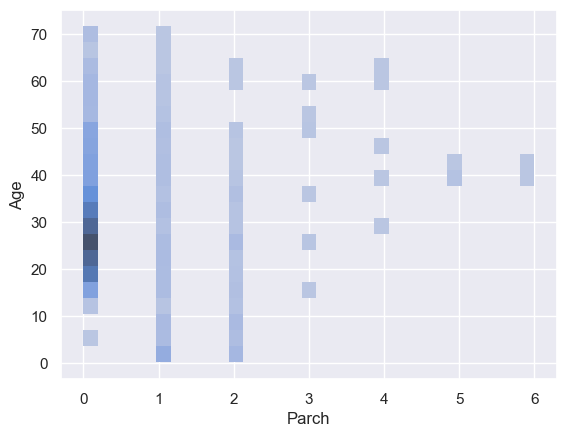

In [133]:
sns.histplot(data=df,
             x='Parch',
             y='Age',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='Parch', ylabel='Age'>

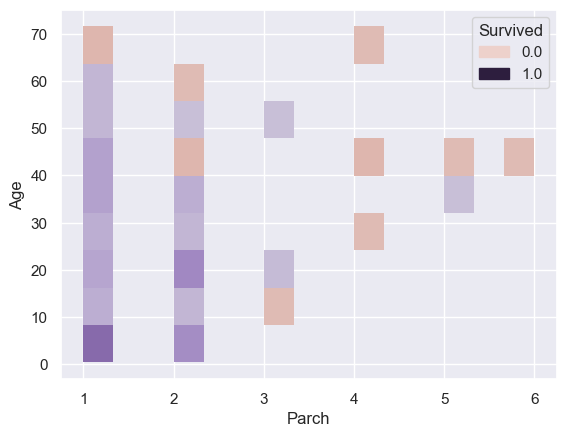

In [134]:
sns.histplot(data=df.loc[df['Parch'] >= 1],
             x='Parch',
             y='Age',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='SibSp', ylabel='Age'>

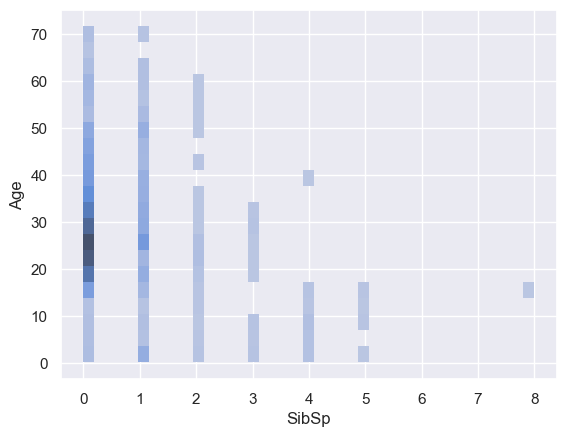

In [135]:
sns.histplot(data=df,
             x='SibSp',
             y='Age',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='Pclass', ylabel='Fare'>

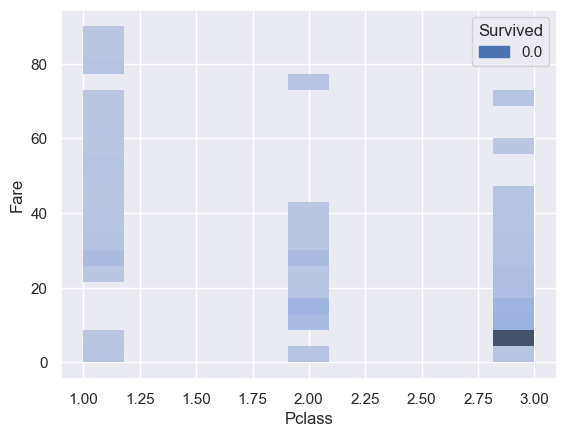

In [136]:
sns.histplot(data=df.loc[(df['Survived'] == 0) & (df['Fare'] < 100)],
             x='Pclass',
             y='Fare',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='Pclass', ylabel='Fare'>

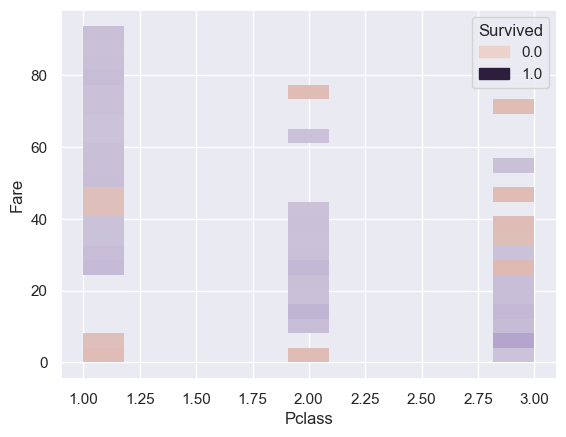

In [137]:
sns.histplot(data=df.loc[(df['Fare'] < 100)],
             x='Pclass',
             y='Fare',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='Pclass', ylabel='Fare'>

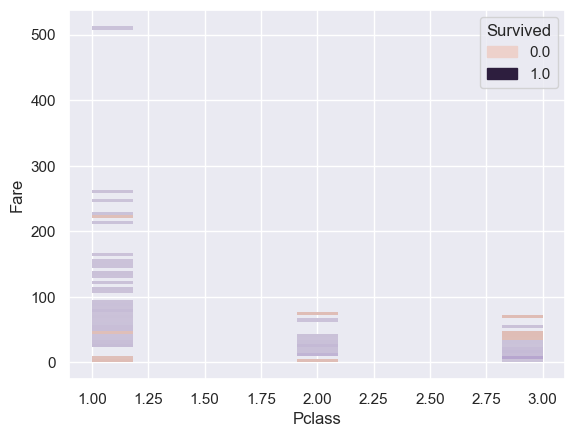

In [139]:
sns.histplot(data=df,
             x='Pclass',
             y='Fare',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


<AxesSubplot: xlabel='SibSp', ylabel='Age'>

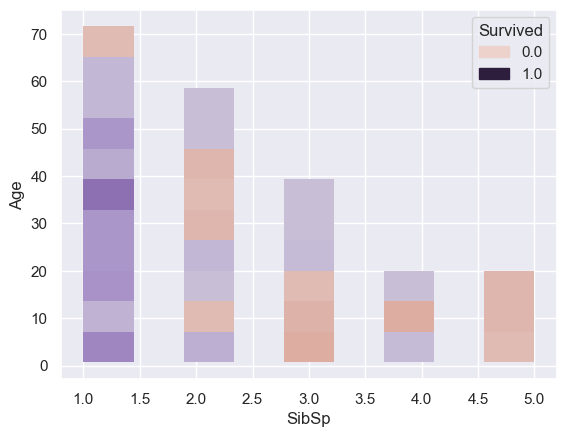

In [140]:
sns.histplot(data=df.loc[df['SibSp'] >= 1],
             x='SibSp',
             y='Age',
             hue='Survived',
             multiple='stack',
             shrink=0.5)


In [141]:
df.loc[(df['Parch'] == 0), 'Parch'] = 0
df.loc[(df['Parch'] > 0) & (df['Parch'] < 3), 'Parch'] = 1
df.loc[df['Parch'] >= 3, 'Parch'] = 2


In [142]:
# Let's cateforize SivSp in three categories:
# 0 - no siblings and spouses,
# 1 - 1-2 siblings or spouses
# 2 - more than 3 siblings or spouses
df.loc[(df['SibSp'] == 0), 'SibSp'] = 0
df.loc[(df['SibSp'] > 0) & (df['SibSp'] < 3), 'SibSp'] = 1
df.loc[df['SibSp'] >= 3, 'SibSp'] = 2


In [143]:
df['SibSp'].unique()


array([1, 0, 2], dtype=int64)

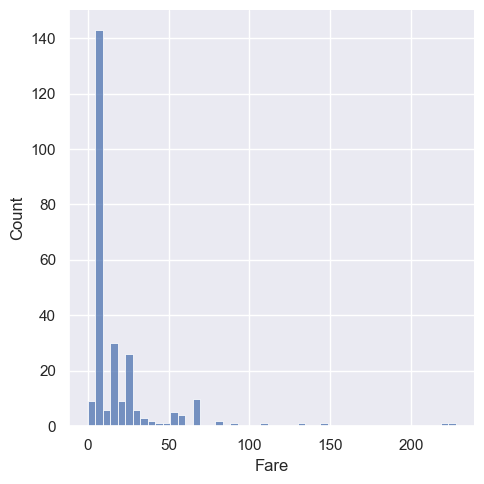

In [144]:
sns.displot(data=df.loc[df['Age'].isna()]['Fare'])


In [145]:
# Let's replace nan values in the Embark column with mode values

from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[['Embarked']] = imp_mean.fit_transform(df[['Embarked']])


In [146]:
def test_independence(col1: pd.Series, col2: pd.Series):
    """
        Function test that categorical col1 and col2 are independent
    """
    cross_tab = pd.crosstab(index=col1, columns=col2)
    res = chi2_contingency(cross_tab)
    if res[1] > 0.05:
        return True
    else:
        return False


In [147]:
cat_columns = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Cabin']

for cat in cat_columns:
    print(cat, 'is independent to y?', test_independence(df[cat], y))


Pclass is independent to y? False
Sex is independent to y? False
Embarked is independent to y? False
SibSp is independent to y? False
Cabin is independent to y? False


In [148]:
df.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_type'],
      dtype='object')

In [149]:
def use_ohe(df, features):
    df_local = pd.DataFrame()
    for feature in features:
        ohe = preprocessing.OneHotEncoder()
        transformed = ohe.fit_transform(df[[feature]])
        df_local[ohe.get_feature_names_out()] = transformed.toarray()
    return df_local


In [150]:
for_ohe = ['Pclass', 'Embarked', 'SibSp', 'Cabin', 'Age_type']

df_final = pd.concat([df['Sex'].apply(lambda x: int(x == 'male')).copy(),
                      df[['Age']].copy(),
                      use_ohe(df, for_ohe)],
                     axis=1)
df_final


,Sex,Age,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N/A,Cabin_T,Age_type_Adult,Age_type_Old,Age_type_Young
0,1,22.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0,38.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,26.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0,35.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,35.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1305,0,39.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1306,1,38.5,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1307,1,NaN,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [151]:
# There are a lot of empty values in the Age column, so I do not want to impute just a mean value
# Let's predict this values using Linear Regression


In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

age_features = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex']

age_x_train = df_final[~df['Age'].isna()].drop('Age', axis=1)[age_features]
age_y_train = df_final[~df['Age'].isna()]['Age']
age_x_test = df_final[df['Age'].isna()].drop('Age', axis=1)[age_features]
age_y_test = df_final[df['Age'].isna()]['Age']

# model = LinearRegression()
model = KNeighborsRegressor()

model.fit(age_x_train, age_y_train)

age_predict = model.predict(age_x_test)
df_final.loc[df_final['Age'].isnull(), 'Age'] = age_predict


In [153]:
# Create categories for Age
# df_final.loc[df['Age'] < 3, 'Age'] = 0
# df_final.loc[(3 <= df_final['Age']) & (df_final['Age'] < 13), 'Age'] = 1
# df_final.loc[(13 <= df_final['Age']) & (df_final['Age'] < 18), 'Age'] = 2
# df_final.loc[(18 <= df_final['Age']) & (df_final['Age'] < 30), 'Age'] = 3
# df_final.loc[(30 <= df_final['Age']) & (df_final['Age'] < 50), 'Age'] = 4
# df_final.loc[(50 <= df_final['Age']), 'Age'] = 5

# df_final = pd.concat([df_final, use_ohe(df_final, ['Age'])], axis=1)
# df_final.drop(['Age'], axis=1, inplace=True)


In [154]:
df_final


,Sex,Age,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,SibSp_0,SibSp_1,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N/A,Cabin_T,Age_type_Adult,Age_type_Old,Age_type_Young
0,1,22.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0,38.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,26.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0,35.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,35.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1,22.7,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1305,0,39.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1306,1,38.5,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1307,1,22.7,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [155]:
df_final.drop(['Cabin_T'], axis=1, inplace=True)


In [156]:
# pclass = df_final[['Pclass_1', 'Pclass_2', 'Pclass_3']].to_numpy()
# sex = df_final[['Sex', 'Sex']].to_numpy()
# np.matmul(pclass,)


In [157]:
from sklearn.model_selection import train_test_split

rng = 42


x = df_final.loc[train_index]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=rng)


Neural Network


In [158]:
import tensorflow as tf
from tensorflow.keras import layers


In [159]:
def create_model(my_learning_rate, my_metrics, shape):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units=shape[1], input_shape=(shape[1], ),
                                    kernel_initializer='normal',
                                    activation='selu'),)

    model.add(tf.keras.layers.Dense(units=shape[1] * 2,
                                    kernel_regularizer=tf.keras.regularizers.l2(
                                        l2=0.03),
                                    kernel_initializer='normal',
                                    activation='selu'),)

    model.add(tf.keras.layers.Dense(units=1,
                                    activation=tf.sigmoid),)

    model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=my_metrics)

    return model


def train_model(model, x, epochs, y,
                batch_size=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=x, y=y, batch_size=batch_size,
                        epochs=epochs, shuffle=shuffle)

    epochs = history.epoch

    hist = pd.DataFrame(history.history)

    return epochs, hist


print("Defined the create_model and train_model functions.")


Defined the create_model and train_model functions.


In [160]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()


print("Defined the plot_curve function.")


Defined the plot_curve function.


In [161]:
x_train.shape


(623, 22)

In [162]:
# The following variables are the hyperparameters.
learning_rate = 0.0005
epochs = 100
batch_size = 3
classification_threshold = 0.6

# Establish the metrics the model will measure.
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                    threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold,
                               name='precision'
                               ),
    tf.keras.metrics.Recall(thresholds=classification_threshold,
                            name="recall"),
]

# Establish the model's topography.
model = create_model(learning_rate, METRICS, x_train.shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 22)                506       
                                                                 
 dense_1 (Dense)             (None, 44)                1012      
                                                                 
 dense_2 (Dense)             (None, 1)                 45        
                                                                 
Total params: 1,563
Trainable params: 1,563
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
208/208 [==============================] - 1s 2ms/step - loss: 0.7136 - accuracy: 0.6276 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/100
208/208 [==============================] - 0s 1ms/step - loss: 0.6465 - accuracy: 0.6485 - precision: 0.8750 - recall: 0.0606  
Epoch 3/100
208/208 [==============================] - 0s 1ms/step - loss: 0.5845 - accuracy: 0.7143 - precision: 0.8841 - recall: 0.2641
Epoch 4/100
208/208 [==============================] - 0s 1ms/step - loss: 0.5432 - accuracy: 0.7432 - precision: 0.8318 - recall: 0.3853
Epoch 5/100
208/208 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7817 - precision: 0.8740 - recall: 0.4805
Epoch 6/100
208/208 [==============================] - 0s 1ms/step - loss: 0.4966 - accuracy: 0.7897 - precision: 0.8623 - recall: 0.5152
Epoch 7/100
208/208 [==============================] - 0s 1ms/step - loss: 0.4844 - accuracy: 0.8042 - precision: 0.8562 - recall: 0.5671
Epoch 8/100
208/208 [===

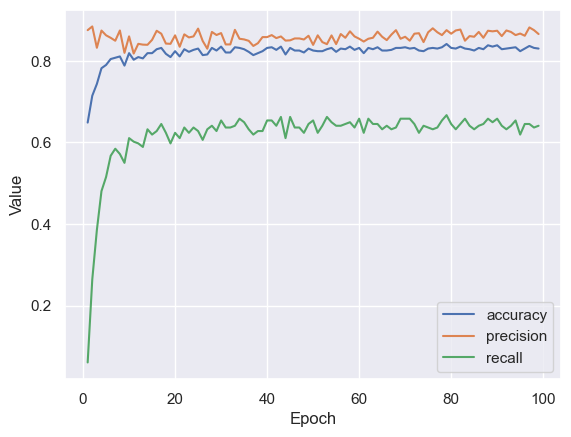

In [163]:
# Train the model on the training set.
epochs, hist = train_model(model, x_train, epochs,
                           y_train, batch_size)

# # Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']

plot_curve(epochs, hist, list_of_metrics_to_plot)


In [164]:
model.evaluate(x=x_test, y=y_test, batch_size=batch_size)


90/90 [==============================] - 0s 1ms/step - loss: 0.4879 - accuracy: 0.7948 - precision: 0.9242 - recall: 0.5495   


[0.4878973960876465,
 0.7947761416435242,
 0.9242424368858337,
 0.5495495200157166]

In [165]:
pred = model.predict(x=df_final.loc[test_index], batch_size=batch_size)
res = [0 if el[0] < classification_threshold else 1 for el in pred]
# print(res)
pd.DataFrame({
    'PassengerId': df.loc[test_index]['PassengerId'],
    'Survived': res
}).to_csv('submission.csv', index=False)


140/140 [==============================] - 0s 1ms/step
